# Differential Equations

*DifferentialEquations.jl* provides functionality for numerical solving several flavors of differential equations. Apart from ordinary differential equations (ODEs) there are capabilities for stochastics ODE, differential algebraic equations (DAEs), and so forth. *DiffEqParamEstim.jl* has the parameter estimation tools, and *Optim.jl* does uni- and multivariate optimizations.

In [12]:
using DifferentialEquations, DiffEqParamEstim, Optim, Flux
using Distributions, Statistics
using Plots

## Ordinary differential equations

We will only focus on ODEs for now: solving them given initial values and parameters, and estimating parameters.

### Example: Population growth

Exponential growth of a single population can be described by equation such as:

$$
P(t) = P_0*e^(kt)
$$

where $$P(t)$$ is population size at time *t* and $$P_0$$ is the intial population size.

The rate of change for population size is therefore:
$$
\frac{dP}{dt} = k
$$

https://www.nature.com/scitable/knowledge/library/how-populations-grow-the-exponential-and-logistic-13240157/

In Julia, we would state this initial value problem as follows:

In [2]:
f(u,p,t) = p*u
u0 = 2. # just two individuals to start off with
p = log(2) # population doubles every unit of time
tspan = (0., 2.0) # time span analyzed
prob = ODEProblem( f, u0, tspan, p )

sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 6-element Vector{Float64}:
 0.0
 0.10761636692328513
 0.43365614146302933
 0.9017045137009299
 1.4600301543215908
 2.0
u: 6-element Vector{Float64}:
 2.0
 2.1548931972343697
 2.7013042503259705
 3.7365439311190327
 5.502281696078546
 7.999998633064019

Because `solve` returns times along with numbers, the results are easily plotted using plot recipes.

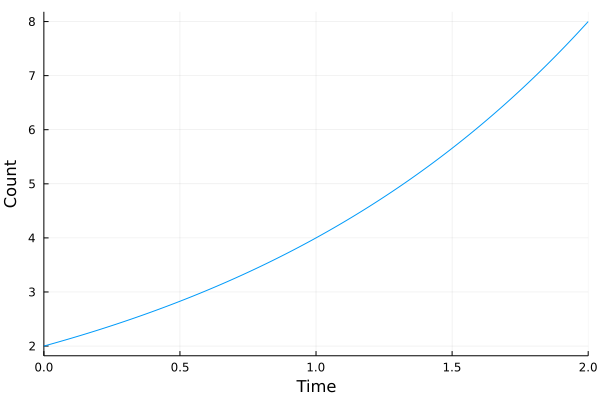

In [3]:
plot( sol, label = "", xlabel="Time", ylabel="Count" )

`solve` is a wrapper which will take an educated guess at the solver most appropriate for your equation and the output you want. A zoo of solvers from *DifferentialEquations.jl* is over [here](https://diffeq.sciml.ai/stable/solvers/ode_solve/).

Some useful options:
* `reltol` and `abstol` help control step size. `reltol` can be thought of as how many digits precision you want, and `abstol` as what happens when you get close to zero.
* `saveat`: a number or array telling the solver explicity at which timepoints to save solutions
* `save_idx`: you may only be interested in certain elements of your solution, e.g. just the dependent variable. Pass the indices of the components you need saved.
* `alg_hints`: `:nonstiff` or `stiff` hints at the nature of your system, default: `alg_hints = [:nonstiff]`

A more complex call to `solve` therefore might look like this:

```
solve( prob,
       Tsit5(), # solver to use
       saveat = 0.1, # timepoint to save
       reltol = 1e-3, # relative tolerance
       abstol = 1e-6 # absolute tolerance
```


### Example: Pharmacokinetics of a tablet

Slightly more complicated, but still an initial value problem. You are now dealing with a system of ODEs.

A drug given orally is transferred from the gastrointestinal tract to systemic circulation using a first order process (defined by `ka`, a rate constant). From systemic circulation (the *central compartment*) it leaves the body by another first order process with rate `kel`. Looking at the differentials, it's just a matter of transferring a substance from one compartment to another. Without scaling for concentrations using volumes of distribution, this is easily stated in Julia.

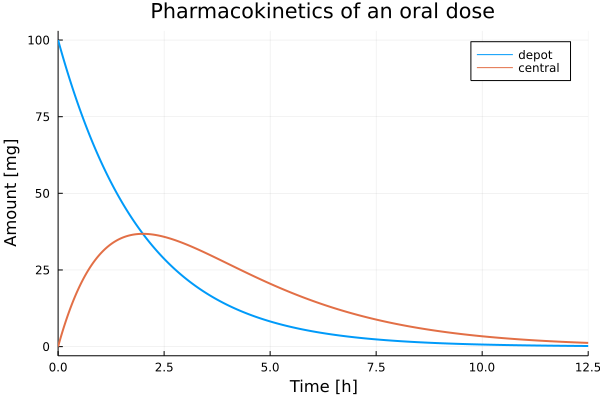

In [4]:
## simple one compartment model with extravascular dosing
function CMT1_oa(du,u,p,t)
  ka, kel = p
  du[1] = -ka *u[1]
  du[2] =  ka *u[1] - kel*u[2]
end

u0 = [100.0, 0] # initial amounts in dosing compartment and central compartment
tspan = (0.0,12.50)
p = [0.5, 0.5] # ka and kel are mass transfer constants for absorption and elimination
prob = ODEProblem(CMT1_oa,u0,tspan,p)

sol = solve(prob, Tsit5(), reltol=1e-2, abstol=1e-2)
plot(sol, label=["depot" "central"], title="Pharmacokinetics of an oral dose", 
    lw=2, xlabel="Time [h]", ylabel="Amount [mg]")

You can follow the changes in amounts present in the dosing compartment (*depot*) and what is measured in the blood (*central*). For a cleaner plot, you can pass `vars`to `plot` because you might only care for one relationship (in this case: what happens in *central*). Pass arrays of tuples to indicate what you would like to see. Time vs central amounts would be `(0,2)` and time vs depot amount `(0,1)'.

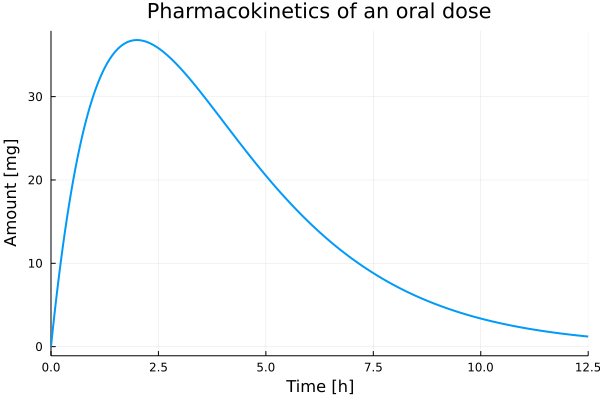

In [5]:
plot(sol, label="", title="Pharmacokinetics of an oral dose", 
    lw=2, xlabel="Time [h]", ylabel="Amount [mg]",
    vars = [(0,2)]
)

## Optimization-based parameter estimation for ODEs

You can use *DiffEqParamEstim.jl* for the estimation of ODE parameters given a set of data. It is a simplified version of *DiffEqFlux.jl*

Returning to exponential population growth: according to [Worldometer](https://www.worldometers.info/world-population), the past years have seen an annual population increase of ~1%. The plot looks like this:

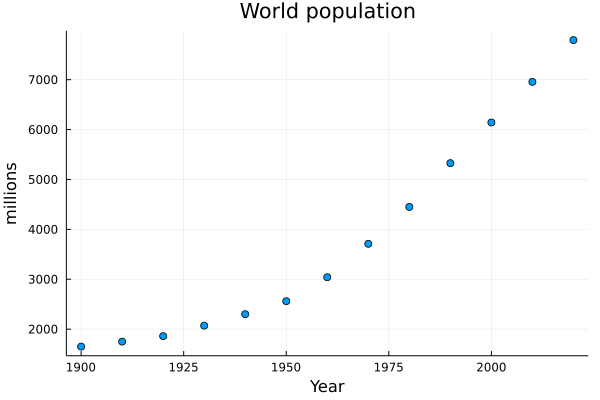

In [6]:
world = [ 1900 1650; 1910 1750; 1920 1860; 1930 2070; 1940 2300; 1950 2560; 1960 3040; 1970 3710; 1980 4450; 1990 5327; 2000 6142; 2010 6956; 2020 7794 ];
world = float(world)
scatter( world[:,1], world[:,2], label="", title="World population", xlabel="Year", ylabel="millions" )

To fit the exponential growth function we can reuse the code from above. The objective function to minimize here (the *cost*, or *loss*) is a variant of [L2Loss](https://juliaml.github.io/LossFunctions.jl/stable/losses/distance/#L2DistLoss-1), a distance-based loss function with a tidy convex shape and a few creature comforts (esp robust performance):

```
L2Loss(t,data;differ_weight=nothing,data_weight=nothing,
              colloc_grad=nothing,dudt=nothing)
```

Easiest way to call this is by passing timepoints of observations in `t` and the respective data points in `data`. For performance and compatibility with a wide range of optimization packages, wrap it as a `build_loss_objective`, combining your loss with a solver. As the problem is non-stiff, a good starting point is one of the explicit Runge-Kutta methods (`Tsit5`, Tsitouras 5/4).

Finally, to get an idea of the solution space for this problem, we'll plot the value of the objective function against the search range.

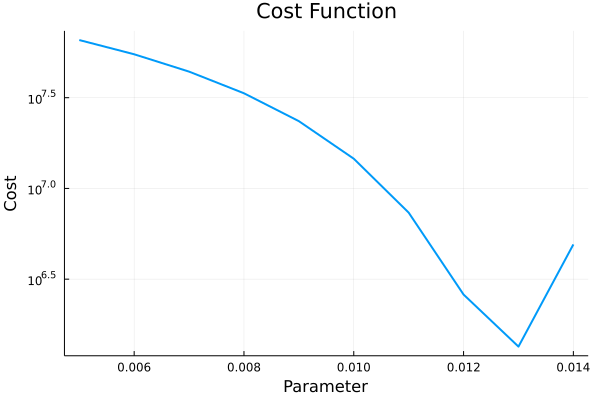

In [7]:
f(u,p,t) = p*u
vals = 0.005:0.001:0.014
tspan = (1900., 2020.)
u0 = world[1,2] # initializing with the earliest measurement, from 1900

prob = ODEProblem(f,u0,tspan)

cost_function = build_loss_objective(prob,Tsit5(),L2Loss(world[:,1],world[:,2]),
                                     maxiters=10,verbose=false);

plot(vals,[cost_function(i) for i in vals],yscale=:log10,
     xaxis = "Parameter", yaxis = "Cost", title = "Cost Function",
     lw = 2, label="")

The minimum appears to somewhere on the right. To get an optimized estimate, use `Optim.optimize`.

In [8]:
result = optimize(cost_function, 0.012, 0.014)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.012000, 0.014000]
 * Minimizer: 1.280518e-02
 * Minimum: 1.256001e+06
 * Iterations: 12
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 13

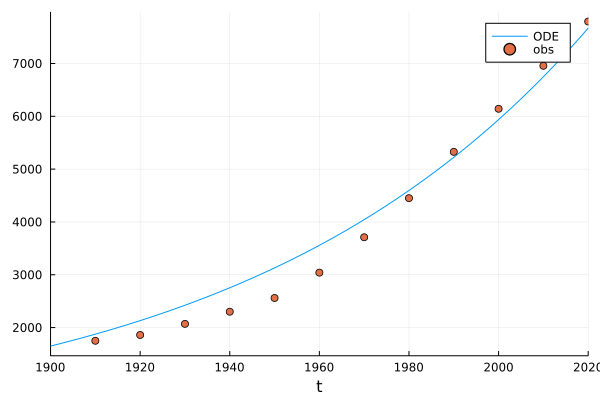

In [9]:
p = result.minimizer
prob = ODEProblem( f, u0, tspan, p )

sol = solve(prob);
plot( sol, label="ODE" )
scatter!( world[:,1], world[:,2], label="obs" ) # performance note: this makes *copies* of the world columns. Prefix with @views to avoid

So maybe saying we have exponential growth of global population is [oversimplifying things](https://www.gapminder.org/factfulness-book/). You can use this fit to extrapolate into the future.

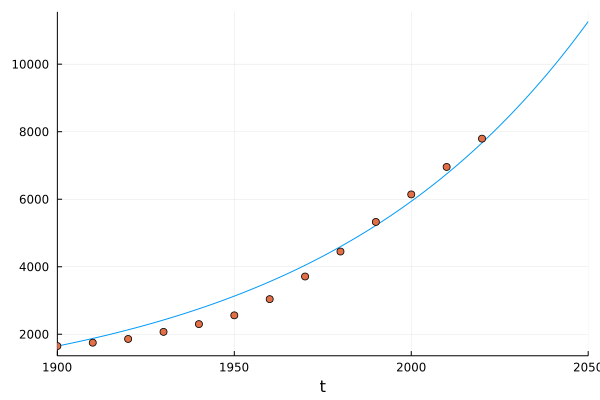

In [10]:
tspan = (1900., 2050.)
prob = ODEProblem( f, u0, tspan, p )

sol = solve(prob);
plot( sol, label="" )
scatter!( world[:,1], world[:,2], label="" )

Aside: pick the right solver for the job. Here's the cost profile for a random stiff solver.

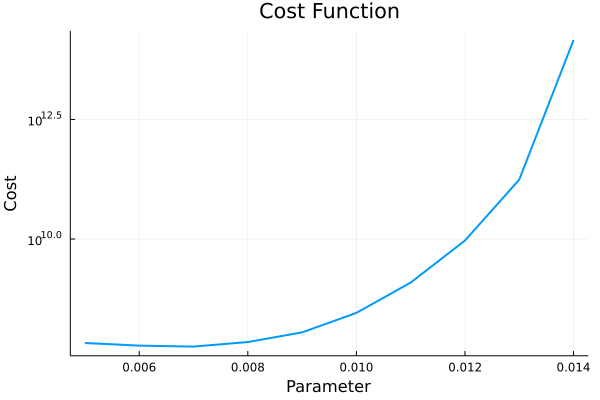

In [11]:
f(u,p,t) = p*u
vals = 0.005:0.001:0.014
tspan = (1900., 2020.)
u0 = world[1,2] # initializing with the earliest measurement, from 1900

prob = ODEProblem(f,u0,tspan)

cost_function = build_loss_objective(prob,ROS3P(),L2Loss(world[:,1],world[:,2]),
                                     maxiters=10,verbose=false);

plot(vals,[cost_function(i) for i in vals],yscale=:log10,
     xaxis = "Parameter", yaxis = "Cost", title = "Cost Function",
     lw = 2, label="")

## Interfacing

You may want to combine the fast numerical solvers of Julia with the visualization and statistics of R. `diffeqr` is available over at [*CRAN*](https://github.com/SciML/diffeqr)

CRAN has the `diffeqr` package for solving differential equations with *DifferentialEquations.jl*.

```
install.packages("diffeqr")
```

Prefix calls with `de$`:

```
de <- diffeqr::diffeq_setup()
```

The world population problem in R, solving with Julia:

```
f <- function( u,p,t ) p*u
p <- 0.12
u0 <- 1650
tspan <- c(1900, 2020)

prob <- de$ODEProblem( f, u0, tspan )
sol = de$solve
```

Setup the package as

```
de <- diffeqr::diffeq_setup()
```

Call functionality by prefixing with `de$`. The population growth problem in R, solved with Julia:

```
f <- function( u,p,t ) p*u
u0 <- 1650
p <- 0.012
tspan <- c( 1900. 2020 )

prob <- de$ODEProblem( f, u0, tspan, p )
sol <- de$solve(prob)
```

And then off to ggplot things if the current plotting tools in Julia are not cutting it for your problem.